# TCN (Temporal Convolution Network)

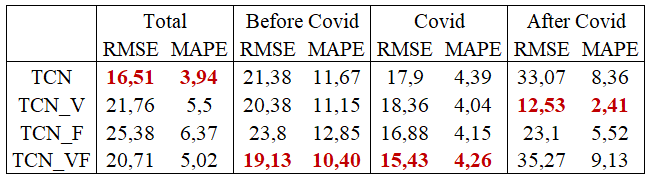  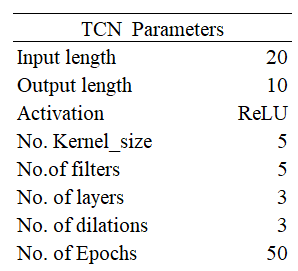

In [1]:
import pandas as pd
import numpy as np
import darts
import yfinance as yf

# visualization
import matplotlib.pyplot as plt

# timeseries with darts
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers import MissingValuesFiller
from darts import concatenate
from darts.models import TCNModel

# RF model test with Covariate
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# darts model evaluation
from darts.metrics import mape, rmse, r2_score

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
The statsforecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


In [2]:
# Data preparation for model development

df =pd.read_csv(r'C:\Users\dicod\Documents\2024\project_with Hamid(2024_3rd semester)\Scientific Project\Data\final_df.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(lambda x:x[0:10])
df['Date'] = pd.to_datetime(df['Date'])


# dataframe to timeseries
ts_price = TimeSeries.from_dataframe(df, time_col=None, value_cols='Close', fill_missing_dates=False, freq='D')
ts_Volume = TimeSeries.from_dataframe(df, time_col=None, value_cols='Volume', fill_missing_dates=False, freq='D')
ts_EPS = TimeSeries.from_dataframe(df, time_col=None, value_cols='EPS', fill_missing_dates=False, freq='D')
ts_PE = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/E', fill_missing_dates=False, freq='D')
ts_PS = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/S', fill_missing_dates=False, freq='D')

# Missing value fillin
transformer = MissingValuesFiller()

ts_price = transformer.transform(ts_price)
ts_Volume = transformer.transform(ts_Volume)
ts_EPS = transformer.transform(ts_EPS)
ts_PE = transformer.transform(ts_PE)
ts_PS = transformer.transform(ts_PS)

# scaler
scaler = Scaler()
scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS = scaler.fit_transform([ts_price, ts_Volume, ts_EPS, ts_PE, ts_PS] )

# concate
my_multivariate_series = concatenate([scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS], axis=1)

# After COVID (from February 1, 2022)
before, after_covid = my_multivariate_series.split_after(653)
                                                        
# Before COVID (up to March 11, 2020)
before_covid, covid = before.split_after(174)

# data split the train and test
train, test = my_multivariate_series.split_after(0.8)
train_covid, test_covid = covid.split_after(0.8)
train_before_covid, test_before_covid = before_covid.split_after(0.8)
train_after_covid, test_after_covid = after_covid.split_after(0.8)

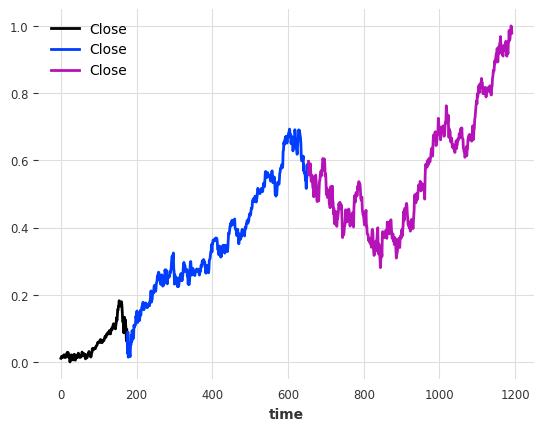

In [3]:
before_covid['Close'].plot()
covid['Close'].plot()
after_covid['Close'].plot()

In [9]:
# define the covarients using train and validation data
# total period
past_cov = my_multivariate_series['Volume']
past_cov_train_vol = train['Volume']
past_cov_test_vol = test['Volume']
past_cov_f = my_multivariate_series[['EPS', 'P/E', 'P/S']]
past_cov_train_f = train[['EPS', 'P/E', 'P/S']]
past_cov_test_f = test[['EPS', 'P/E', 'P/S']]
past_cov_vf = my_multivariate_series[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_train_vf = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_test_vf = test[['Volume', 'EPS', 'P/E', 'P/S']]

# before covid
pc_train_before_vol = train_before_covid['Volume']
pc_test_before_vol = test_before_covid['Volume'] 
pc_train_before_f = train_before_covid[['EPS', 'P/E', 'P/S']]
pc_test_before_f = test_before_covid[['EPS', 'P/E', 'P/S']] 
pc_train_before_vf = train_before_covid[['Volume', 'EPS', 'P/E', 'P/S']]
pc_test_before_vf = test_before_covid[['Volume', 'EPS', 'P/E', 'P/S']] 

# covid
pc_train_covid_vol = train_covid['Volume']
pc_test_covid_vol = test_covid['Volume']
pc_train_covid_f = train_covid[['EPS', 'P/E', 'P/S']]
pc_test_covid_f = test_covid[['EPS', 'P/E', 'P/S']]
pc_train_covid_vf = train_covid[['Volume', 'EPS', 'P/E', 'P/S']]
pc_test_covid_vf = test_covid[['Volume', 'EPS', 'P/E', 'P/S']]

# after covid
pc_train_after_covid_vol = train_after_covid['Volume']
pc_test_after_covid_vol = test_after_covid['Volume']
pc_train_after_covid_f = train_after_covid[['EPS', 'P/E', 'P/S']]
pc_test_after_covid_f = test_after_covid[['EPS', 'P/E', 'P/S']]
pc_train_after_covid_vf = train_after_covid[['Volume', 'EPS', 'P/E', 'P/S']]
pc_test_after_covid_vf = test_after_covid[['Volume', 'EPS', 'P/E', 'P/S']]

### Commom parameters

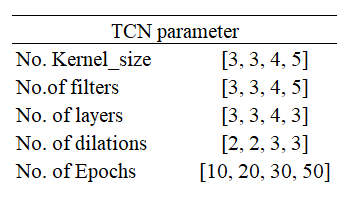

### 1. TCN model test without Covariates

In [7]:
TCN_par1 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2, weight_norm=True,
    n_epochs=10, random_state = 42
)
# total 
TCN_par1.fit(train['Close'])

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_Total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_Total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_Total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par1.fit(train_before_covid['Close'])

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("RMSE_before_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_before_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_before_covid  = %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par1.fit(train_covid['Close'])

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("RMSE_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_covid  = %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par1.fit(train_after_covid['Close'])

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("RMSE_after_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_after_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_after_covid  = %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 168   
----------------------------------------------------
168       Trainable params
0         Non-trainable params
168       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_Total_RMSE = 34.30
TCN_Total_R2 = -2.25
TCN_Total_MAPE = 8.80


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_before_covid  = 10.48
R2_before_covid  = -4036.99
MAPE_before_covid  = 6.43


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_covid  = 17.52
R2_covid  = -5.09
MAPE_covid  = 4.99


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_after_covid  = 28.05
R2_after_covid  = -5.38
MAPE_after_covid  = 6.91


In [8]:
TCN_par2 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2, weight_norm=True,
    n_epochs=20, random_state=42
)
# total 
TCN_par2.fit(train['Close'])

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par2_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par2.fit(train_before_covid['Close'])

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par2_Covid_Before_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par2.fit(train_covid['Close'])

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par2_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par2.fit(train_after_covid['Close'])

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par2_Covid_After_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_After_MAPE = %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 168   
----------------------------------------------------
168       Trainable params
0         Non-trainable params
168       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_total_RMSE = 31.70
TCN_par2_total_R2 = -1.06
TCN_par2_total_MAPE = 8.27


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_Before_RMSE = 4.50
TCN_par2_Covid_Before_R2= -2.74
TCN_par2_Covid_Before_MAPE= 2.07


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_RMSE= 17.84
TCN_par2_Covid_R2= -2.46
TCN_par2_Covid_MAPE= 5.04


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_After_RMSE = 24.33
TCN_par2_Covid_After_R2= -2.18
TCN_par2_Covid_After_MAPE = 5.88


In [5]:
TCN_par3 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=4, num_filters=4, num_layers=3, dilation_base=3, weight_norm=True,
    n_epochs=30, random_state = 42
)
# total 
TCN_par3.fit(train['Close'])

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par3_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par3.fit(train_before_covid['Close'])

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par3_Covid_Before_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_Before_R2_= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par3.fit(train_covid['Close'])

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par3_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par3.fit(train_after_covid['Close'])

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par3_Covid_After_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 343   
----------------------------------------------------
343       Trainable params
0         Non-trainable params
343       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_total_RMSE = 14.88
TCN_par3_total_R2 = 0.77
TCN_par3_total_MAPE = 3.46


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_Covid_Before_RMSE = 20.62
TCN_par3_Covid_Before_R2_= -6.29
TCN_par3_Covid_Before_MAPE= 11.29


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_Covid_RMSE= 15.76
TCN_par3_Covid_R2= -0.78
TCN_par3_Covid_MAPE= 3.90


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_Covid_After_RMSE = 16.82
TCN_par3_Covid_After_R2= -0.14
TCN_par3_Covid_After_MAPE= 3.58


In [6]:
TCN_par4 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=5, num_filters=5, num_layers=3, dilation_base=3, weight_norm=True,
    n_epochs=50, random_state=42
)
# total 
TCN_par4.fit(train['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par4_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par4.fit(train_before_covid['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par4_Covid_Before_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par4.fit(train_covid['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par4_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par4.fit(train_after_covid['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par4_Covid_After_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 618   
----------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_total_RMSE = 16.51
TCN_par4_total_R2 = 0.69
TCN_par4_total_MAPE = 3.94


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_Before_RMSE= 21.38
TCN_par4_Covid_Before_R2= -6.59
TCN_par4_Covid_Before_MAPE= 11.67


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_RMSE= 17.90
TCN_par4_Covid_R2= -0.94
TCN_par4_Covid_MAPE= 4.39


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_After_RMSE= 33.07
TCN_par4_Covid_After_R2= -8.37
TCN_par4_Covid_After_MAPE= 8.36


### 1. TCN model test with "Volume Covariates"

### Table 1: Microsoft Stock Price Prediction with Backtest(10days): 

We used "MSFT Close price" and "MSFT Volume(Covariate)" for Stock price prediction.

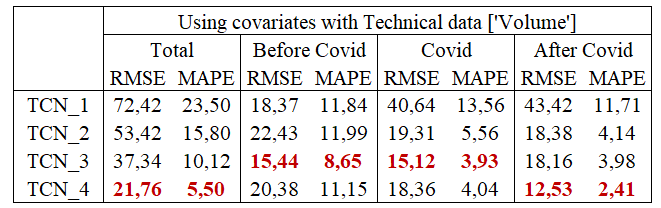


In [5]:
TCN_par1 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2, weight_norm=True,
    n_epochs=10, random_state = 42
)
# total 
TCN_par1.fit(train['Close'], past_covariates=past_cov_train_vol)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_Total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_Total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_Total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par1.fit(train_before_covid['Close'], past_covariates=pc_train_before_vol)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("RMSE_before_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_before_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_before_covid  = %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par1.fit(train_covid['Close'], past_covariates=pc_train_covid_vol)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("RMSE_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_covid  = %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par1.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vol)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("RMSE_after_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_after_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_after_covid  = %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 180   
----------------------------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GP

TCN_Total_RMSE = 72.42
TCN_Total_R2 = -27.88
TCN_Total_MAPE = 23.50


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 180   
----------------------------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False


RMSE_before_covid  = 18.37
R2_before_covid  = -10.32
MAPE_before_covid  = 11.84


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 180   
----------------------------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_covid  = 40.64
R2_covid  = -32.54
MAPE_covid  = 13.56


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_after_covid  = 43.42
R2_after_covid  = -9.68
MAPE_after_covid  = 11.71


In [8]:
TCN_par2 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2, weight_norm=True,
    n_epochs=20, random_state=42
)
# total 
TCN_par2.fit(train['Close'], past_covariates=past_cov_train_vol)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par2_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par2.fit(train_before_covid['Close'], past_covariates=pc_train_before_vol)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par2_Covid_Before_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par2.fit(train_covid['Close'], past_covariates=pc_train_covid_vol)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par2_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par2.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vol)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par2_Covid_After_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_After_MAPE = %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 180   
----------------------------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_total_RMSE = 53.43
TCN_par2_total_R2 = -8.06
TCN_par2_total_MAPE = 15.80


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_Before_RMSE = 22.43
TCN_par2_Covid_Before_R2= -5.12
TCN_par2_Covid_Before_MAPE= 11.99


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_RMSE= 19.31
TCN_par2_Covid_R2= -3.50
TCN_par2_Covid_MAPE= 5.56


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_After_RMSE = 18.38
TCN_par2_Covid_After_R2= -0.52
TCN_par2_Covid_After_MAPE = 4.14


In [9]:
TCN_par3 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=4, num_filters=4, num_layers=3, dilation_base=3, weight_norm=True,
    n_epochs=30, random_state = 42
)
# total 
TCN_par3.fit(train['Close'], past_covariates=past_cov_train_vol)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par3_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par3.fit(train_before_covid['Close'], past_covariates=pc_train_before_vol)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par3_Covid_Before_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_Before_R2_= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par3.fit(train_covid['Close'], past_covariates=pc_train_covid_vol)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par3_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par3.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vol)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par3_Covid_After_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 363   
----------------------------------------------------
363       Trainable params
0         Non-trainable params
363       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_total_RMSE = 37.34
TCN_par3_total_R2 = -2.24
TCN_par3_total_MAPE = 10.12


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_Covid_Before_RMSE = 15.44
TCN_par3_Covid_Before_R2_= -13.96
TCN_par3_Covid_Before_MAPE= 8.65



  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 363   
----------------------------------------------------
363       Trainable params
0         Non-trainable params
363       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_Covid_RMSE= 15.12
TCN_par3_Covid_R2= -0.90
TCN_par3_Covid_MAPE= 3.93


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_Covid_After_RMSE = 18.16
TCN_par3_Covid_After_R2= -0.45
TCN_par3_Covid_After_MAPE= 3.98


In [7]:
TCN_par4 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=5, num_filters=5, num_layers=3, dilation_base=3, weight_norm=True,
    n_epochs=50, random_state=42
)
# total 
TCN_par4.fit(train['Close'], past_covariates=past_cov_train_vol)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par4_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par4.fit(train_before_covid['Close'], past_covariates=pc_train_before_vol)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par4_Covid_Before_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par4.fit(train_covid['Close'], past_covariates=pc_train_covid_vol)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par4_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par4.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vol)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par4_Covid_After_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 648   
----------------------------------------------------
648       Trainable params
0         Non-trainable params
648       Total params
0.003     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_total_RMSE = 21.76
TCN_par4_total_R2 = 0.39
TCN_par4_total_MAPE = 5.50


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_Before_RMSE= 20.38
TCN_par4_Covid_Before_R2= -6.98
TCN_par4_Covid_Before_MAPE= 11.15


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_RMSE= 18.36
TCN_par4_Covid_R2= -0.94
TCN_par4_Covid_MAPE= 4.46



  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 648   
----------------------------------------------------
648       Trainable params
0         Non-trainable params
648       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_After_RMSE= 12.53
TCN_par4_Covid_After_R2= 0.46
TCN_par4_Covid_After_MAPE= 2.41


### 2. TCN model test with Covariates,"fundamental data" - EPS, P/E, P/S

### Table 2: Microsoft Stock Price Prediction with Backtest(10days): 

We used "MSFT Close price" and "MSFT EPS, P/E, P/S(Covariate)" for Stock price prediction.

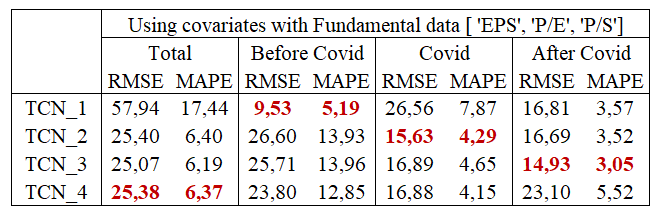

In [10]:
TCN_par1 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2, weight_norm=True,
    n_epochs=10, random_state = 42
)
# total 
TCN_par1.fit(train['Close'], past_covariates=past_cov_train_f)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_Total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_Total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_Total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par1.fit(train_before_covid['Close'], past_covariates=pc_train_before_f)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("RMSE_before_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_before_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_before_covid  = %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par1.fit(train_covid['Close'], past_covariates=pc_train_covid_f)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("RMSE_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_covid  = %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par1.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_f)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("RMSE_after_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_after_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_after_covid  = %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 204   
----------------------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_Total_RMSE = 57.94
TCN_Total_R2 = -9.97
TCN_Total_MAPE = 17.44


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 204   
----------------------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RMSE_before_covid  = 9.53
R2_before_covid  = -0.84
MAPE_before_covid  = 5.19


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 204   
----------------------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_covid  = 26.56
R2_covid  = -9.02
MAPE_covid  = 7.87


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 204   
----------------------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_after_covid  = 16.81
R2_after_covid  = -0.27
MAPE_after_covid  = 3.57


In [11]:
TCN_par2 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2, weight_norm=True,
    n_epochs=20, random_state=42
)
# total 
TCN_par2.fit(train['Close'], past_covariates=past_cov_train_f)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par2_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par2.fit(train_before_covid['Close'], past_covariates=pc_train_before_f)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par2_Covid_Before_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par2.fit(train_covid['Close'], past_covariates=pc_train_covid_f)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par2_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par2.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_f)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par2_Covid_After_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_After_MAPE = %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 204   
----------------------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_total_RMSE = 25.40
TCN_par2_total_R2 = 0.11
TCN_par2_total_MAPE = 6.40


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 204   
----------------------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TCN_par2_Covid_Before_RMSE = 26.60
TCN_par2_Covid_Before_R2= -5.45
TCN_par2_Covid_Before_MAPE= 13.93


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 204   
----------------------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_RMSE= 15.63
TCN_par2_Covid_R2= -1.22
TCN_par2_Covid_MAPE= 4.29


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 204   
----------------------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_After_RMSE = 16.69
TCN_par2_Covid_After_R2= -0.31
TCN_par2_Covid_After_MAPE = 3.52


In [ ]:
TCN_par3 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=4, num_filters=4, num_layers=3, dilation_base=3, weight_norm=True,
    n_epochs=30, random_state = 42
)
# total 
TCN_par3.fit(train['Close'], past_covariates=past_cov_train_f)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par3_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par3.fit(train_before_covid['Close'], past_covariates=pc_train_before_f)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par3_Covid_Before_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_Before_R2_= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par3.fit(train_covid['Close'], past_covariates=pc_train_covid_f)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par3_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par3.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_f)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par3_Covid_After_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

In [12]:
TCN_par4 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=5, num_filters=5, num_layers=3, dilation_base=3, weight_norm=True,
    n_epochs=50, random_state=42
)
# total 
TCN_par4.fit(train['Close'], past_covariates=past_cov_train_f)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par4_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par4.fit(train_before_covid['Close'], past_covariates=pc_train_before_f)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par4_Covid_Before_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par4.fit(train_covid['Close'], past_covariates=pc_train_covid_f)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par4_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par4.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_f)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_f,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par4_Covid_After_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 708   
----------------------------------------------------
708       Trainable params
0         Non-trainable params
708       Total params
0.003     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_total_RMSE = 25.38
TCN_par4_total_R2 = -0.03
TCN_par4_total_MAPE = 6.37


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False


TCN_par4_Covid_Before_RMSE= 23.80
TCN_par4_Covid_Before_R2= -7.48
TCN_par4_Covid_Before_MAPE= 12.85


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 708   
----------------------------------------------------
708       Trainable params
0         Non-trainable params
708       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_RMSE= 16.88
TCN_par4_Covid_R2= -1.44
TCN_par4_Covid_MAPE= 4.15



  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 708   
----------------------------------------------------
708       Trainable params
0         Non-trainable params
708       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_After_RMSE= 23.10
TCN_par4_Covid_After_R2= -1.84
TCN_par4_Covid_After_MAPE= 5.52


### 3. TCN model test with Covariates,"Technical and fundamental" - Volume, EPS, P/E, P/S

### Table 3: Microsoft Stock Price Prediction with Backtest(10days): 

We used "MSFT Close price" and "MSFT Volumn, EPS, P/E, P/S(Covariate)" for Stock price prediction.

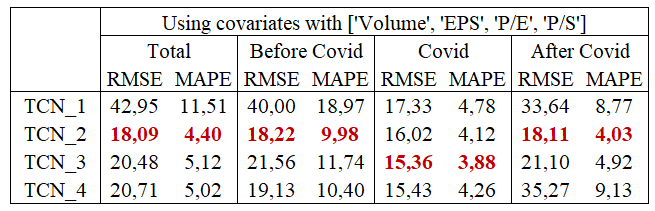

In [14]:
TCN_par1 = TCNModel(
input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2, weight_norm=True,
    n_epochs=10, random_state = 42
)
# total 
TCN_par1.fit(train['Close'], past_covariates=past_cov_train_vf)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_Total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_Total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_Total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par1.fit(train_before_covid['Close'], past_covariates=pc_train_before_vf)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("RMSE_before_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_before_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_before_covid  = %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par1.fit(train_covid['Close'], past_covariates=pc_train_covid_vf)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("RMSE_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_covid  = %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par1.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vf)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("RMSE_after_covid  = %.2f" % rmse(pred_price,actual_price))
print("R2_after_covid  = %.2f" % r2_score(pred_price,actual_price))
print("MAPE_after_covid  = %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 216   
----------------------------------------------------
216       Trainable params
0         Non-trainable params
216       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_Total_RMSE = 42.95
TCN_Total_R2 = -5.20
TCN_Total_MAPE = 11.51


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_before_covid  = 40.00
R2_before_covid  = -18.32
MAPE_before_covid  = 18.97


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_covid  = 17.33
R2_covid  = -3.51
MAPE_covid  = 4.78


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE_after_covid  = 33.64
R2_after_covid  = -5.48
MAPE_after_covid  = 8.77


In [15]:
TCN_par2 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2, weight_norm=True,
    n_epochs=20, random_state=42
)
# total 
TCN_par2.fit(train['Close'], past_covariates=past_cov_train_vf)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par2_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par2.fit(train_before_covid['Close'], past_covariates=pc_train_before_vf)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par2_Covid_Before_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par2.fit(train_covid['Close'], past_covariates=pc_train_covid_vf)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par2_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par2.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vf)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par2_Covid_After_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par2_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par2_Covid_After_MAPE = %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 216   
----------------------------------------------------
216       Trainable params
0         Non-trainable params
216       Total params
0.001     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_total_RMSE = 18.09
TCN_par2_total_R2 = 0.56
TCN_par2_total_MAPE = 4.40


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_Before_RMSE = 18.22
TCN_par2_Covid_Before_R2= -22.72
TCN_par2_Covid_Before_MAPE= 9.98


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_RMSE= 16.02
TCN_par2_Covid_R2= -0.86
TCN_par2_Covid_MAPE= 4.12


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par2_Covid_After_RMSE = 18.11
TCN_par2_Covid_After_R2= -0.24
TCN_par2_Covid_After_MAPE = 4.03


In [16]:
TCN_par3 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=4, num_filters=4, num_layers=3, dilation_base=3, weight_norm=True,
    n_epochs=30, random_state = 42
)
# total 
TCN_par3.fit(train['Close'], past_covariates=past_cov_train_vf)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par3_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par3.fit(train_before_covid['Close'], past_covariates=pc_train_before_vf)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par3_Covid_Before_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_Before_R2_= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par3.fit(train_covid['Close'], past_covariates=pc_train_covid_vf)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par3_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par3.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vf)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par3_Covid_After_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par3_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par3_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 423   
----------------------------------------------------
423       Trainable params
0         Non-trainable params
423       Total params
0.002     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_total_RMSE = 20.48
TCN_par3_total_R2 = 0.39
TCN_par3_total_MAPE = 5.12


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_Covid_Before_RMSE = 21.56
TCN_par3_Covid_Before_R2_= -6.25
TCN_par3_Covid_Before_MAPE= 11.74


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_Covid_RMSE= 15.36
TCN_par3_Covid_R2= -1.25
TCN_par3_Covid_MAPE= 3.88


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par3_Covid_After_RMSE = 21.10
TCN_par3_Covid_After_R2= -1.11
TCN_par3_Covid_After_MAPE= 4.92


In [17]:
TCN_par4 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=5, num_filters=5, num_layers=3, dilation_base=3, weight_norm=True,
    n_epochs=50, random_state=42
)
# total 
TCN_par4.fit(train['Close'], past_covariates=past_cov_train_vf)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par4_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par4.fit(train_before_covid['Close'], past_covariates=pc_train_before_vf)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par4_Covid_Before_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par4.fit(train_covid['Close'], past_covariates=pc_train_covid_vf)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par4_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par4.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vf)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vf,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par4_Covid_After_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 708   
----------------------------------------------------
708       Trainable params
0         Non-trainable params
708       Total params
0.003     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_total_RMSE = 20.71
TCN_par4_total_R2 = 0.69
TCN_par4_total_MAPE = 5.02


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_Before_RMSE= 19.13
TCN_par4_Covid_Before_R2= -3.75
TCN_par4_Covid_Before_MAPE= 10.40


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_RMSE= 15.43
TCN_par4_Covid_R2= -1.15
TCN_par4_Covid_MAPE= 4.26


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_After_RMSE= 35.27
TCN_par4_Covid_After_R2= -11.62
TCN_par4_Covid_After_MAPE= 9.13


In [18]:
TCN_par4 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=5, num_filters=5, num_layers=3, dilation_base=3, weight_norm=True,
    n_epochs=50, random_state=42
)
# total 
TCN_par4.fit(train['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par4_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par4.fit(train_before_covid['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par4_Covid_Before_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par4.fit(train_covid['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par4_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par4.fit(train_after_covid['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par4_Covid_After_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 618   
----------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_total_RMSE = 16.51
TCN_par4_total_R2 = 0.69
TCN_par4_total_MAPE = 3.94


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_Before_RMSE= 21.38
TCN_par4_Covid_Before_R2= -6.59
TCN_par4_Covid_Before_MAPE= 11.67


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_RMSE= 17.90
TCN_par4_Covid_R2= -0.94
TCN_par4_Covid_MAPE= 4.39


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_After_RMSE= 33.07
TCN_par4_Covid_After_R2= -8.37
TCN_par4_Covid_After_MAPE= 8.36


In [10]:
TCN_par4 = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    kernel_size=6, num_filters=6, num_layers=6, dilation_base=3, weight_norm=True,
    n_epochs=50, random_state=42
)
# total 
TCN_par4.fit(train['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test['Close'])

print("TCN_par4_total_RMSE = %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_total_R2 = %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_total_MAPE = %.2f" % mape(pred_price,actual_price))

# before covid 
TCN_par4.fit(train_before_covid['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_before_covid['Close'])

print("TCN_par4_Covid_Before_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_Before_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_Before_MAPE= %.2f" % mape(pred_price,actual_price))

# covid 
TCN_par4.fit(train_covid['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_covid['Close'])

print("TCN_par4_Covid_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_MAPE= %.2f" % mape(pred_price,actual_price))

# after covid 
TCN_par4.fit(train_after_covid['Close'])

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
actual_price = scaler.inverse_transform(test_after_covid['Close'])

print("TCN_par4_Covid_After_RMSE= %.2f" % rmse(pred_price,actual_price))
print("TCN_par4_Covid_After_R2= %.2f" % r2_score(pred_price,actual_price))
print("TCN_par4_Covid_After_MAPE= %.2f" % mape(pred_price,actual_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 2.4 K 
----------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_total_RMSE = 16.78
TCN_par4_total_R2 = 0.70
TCN_par4_total_MAPE = 4.05


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_Before_RMSE= 24.22
TCN_par4_Covid_Before_R2= -7.94
TCN_par4_Covid_Before_MAPE= 13.07


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_RMSE= 17.36
TCN_par4_Covid_R2= -0.82
TCN_par4_Covid_MAPE= 4.20


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN_par4_Covid_After_RMSE= 22.56
TCN_par4_Covid_After_R2= -2.04
TCN_par4_Covid_After_MAPE= 5.29
